## 1D Vlasov–Ampere system

$$
\frac{\partial f}{\partial t} + \upsilon \frac{\partial f}{\partial x}
- E(t,x) \frac{\partial f}{\partial \upsilon} = 0
$$

$$
\frac{\partial E}{\partial t} = - J = \int f\upsilon \; d\upsilon
$$

## Algorithm 

- For each $j$ compute discrete Fourier transform in $x$ of $f^n(x_i,\upsilon_j)$ yielding $f_k^n(\upsilon_j)$, 

- For $ k \neq 0 $

    - Compute 
    
    $$f^{n+1}_k(\upsilon_j) = e^{−2i\pi k \upsilon
    \Delta t/L} f_n^k(\upsilon_j),$$
    
    - Compute 
    
    $$\rho_k^{n+1} = \Delta \upsilon \sum_j􏰄 f^{n+1}_k(\upsilon_j),$$
    
    - Compute
    
    $$E^{n+1}_k = \rho^{n+1}_k L/(2i\pi k \epsilon_0),$$
    
- For $k = 0$ do nothing: 

$$f_{n+1}(\upsilon_j) = f^n_k(\upsilon_j), E^{n+1}_k = E^n_k$$.

- Perform inverse discrete Fourier transform of $E^{n+1}_k$ and for each $j$ of $f^{n+1}_k (\upsilon_j)$.

In [8]:
using ProgressMeter, FFTW, Plots, LinearAlgebra
using BenchmarkTools, Statistics

In [9]:
"""

    UniformMesh(start, stop, length)

    1D uniform mesh data.

    length   : number of points
    length-1 : number of cells

    To remove the last point, set endpoint=false

"""
struct UniformMesh

   start    :: Float64
   stop     :: Float64
   length   :: Int
   step     :: Float64
   points   :: Vector{Float64}
   endpoint :: Bool

   function UniformMesh(start, stop, length::Int; endpoint=true)

       if (endpoint)
           points = range(start, stop=stop, length=length)
       else
           points = range(start, stop=stop, length=length+1)[1:end-1]
       end
       step = points[2]-points[1]

       new( start, stop, length, step, points, endpoint)

   end

end


UniformMesh

In [10]:
using FFTW, LinearAlgebra

abstract type AbstractAdvection end
abstract type AdvectionType end

In [41]:
import FFTW: fft!, ifft!
import LinearAlgebra: transpose

export Ampere

struct Ampere end

"""

    advection!( fᵀ, mesh1, mesh2, E, dt, type, axis ) 

    ∂f/∂t − υ∂f/∂x  = 0
    ∂E/∂t = −J = ∫ fυ dυ
    ∂f/∂t − E(x) ∂f/∂υ  = 0

"""
struct AmpereAdvection <: AbstractAdvection
    
    mesh :: UniformMesh
    kx   :: Vector{Float64}

    function AmpereAdvection( mesh )
        
        nx  = mesh.length
        dx  = mesh.step
        Lx  = mesh.stop - mesh.start
        kx  = zeros(Float64, nx)
        kx .= 2π/Lx * [0:nx÷2-1;-nx÷2:-1]
        new( mesh, kx)
      
    end

end

function (adv :: AmpereAdvection)( fᵗ  :: Array{ComplexF64,2}, 
		                           e   :: Vector{ComplexF64}, 
		                           dt  :: Float64 )
    fft!(fᵗ, 1)
    fᵗ .= fᵗ .* exp.(-1im * dt * adv.kx * transpose(e))
    ifft!(fᵗ, 1)

end

function (adv :: AmpereAdvection)( f   :: Array{ComplexF64,2}, 
		                           e   :: Vector{ComplexF64}, 
		                           v   :: Vector{Float64}, 
		                           dt  :: Float64 )
    
    ev = exp.(-1im*dt * adv.kx * transpose(v))    
    
    fft!(f,1)
    f .= f .* ev
    dv = v[2]-v[1]
    ρ = dv * vec(sum(f,dims=2))  
    for i in 2:length(e)
        e[i] = -1im * ρ[i] ./ adv.kx[i]
    end
    e[1] = 0.0
    ifft!(f,1)
    ifft!(e)
    e .= real(e)
end



In [42]:
using FFTW, LinearAlgebra

"""
    bspline(p, j, x)

Return the value at x in [0,1[ of the B-spline with integer nodes of degree p with support starting at j.
Implemented recursively using the [De Boor's Algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

```math
B_{i,0}(x) := \\left\\{
\\begin{matrix}
1 & \\mathrm{if}  \\quad t_i ≤ x < t_{i+1} \\\\
0 & \\mathrm{otherwise} 
\\end{matrix}
\\right.
```

```math
B_{i,p}(x) := \\frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x) 
+ \\frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
```
"""
function bspline(p::Int, j::Int, x::Float64)
   if p == 0
       if j == 0
           return 1.0
       else
           return 0.0
       end
   else
       w = (x - j) / p
       w1 = (x - j - 1) / p
   end
   return (w * bspline(p - 1, j, x) + (1 - w1) * bspline(p - 1, j + 1, x))
end

export BSpline

struct BSpline <: AdvectionType
    p :: Int64
end


"""
    BsplineAdvection(p, mesh)

Advection type

"""
mutable struct BSplineAdvection <: AbstractAdvection
    
    p        :: Int64 
    mesh     :: UniformMesh
    modes    :: Vector{Float64}
    eig_bspl :: Vector{Float64}
    eigalpha :: Vector{Complex{Float64}}
    
    function BSplineAdvection( p, mesh )

        println(" Create BSL advection with bspline of degree $p ")
        @show nx  = mesh.length

        modes     = zeros(Float64, nx)
        modes    .= [2π * i / nx for i in 0:nx-1]
        eig_bspl  = zeros(Float64, nx)
        eig_bspl  = zeros(Float64, nx)
        eig_bspl .= bspline(p, -div(p+1,2), 0.0)
        for i in 1:div(p+1,2)-1
            eig_bspl .+= bspline(p, i-(p+1)÷2, 0.0) * 2 .* cos.(i * modes)
        end
        eigalpha  = zeros(Complex{Float64}, nx)
        new( p, mesh, modes, eig_bspl, eigalpha )
    end
    
end

"""

    advection( f, v, dt)

Instantiate an advection type 

```julia
advection! = Advection( p, mesh)

advection!(f, v, dt)
```

"""
function (adv :: BSplineAdvection)(f    :: Array{Complex{Float64},2}, 
                                   v    :: Vector{Float64}, 
                                   dt   :: Float64)
    
   nx = adv.mesh.length
   nv = length(v)
   dx = adv.mesh.step
    
   fft!(f,1)
    
   for j in 1:nv

      @inbounds alpha = dt * v[j] / dx
      # compute eigenvalues of cubic splines evaluated at displaced points
      ishift = floor(-alpha)
      beta   = -ishift - alpha
      fill!(adv.eigalpha,0.0im)
      for i in -div(adv.p-1,2):div(adv.p+1,2)
         adv.eigalpha .+= (bspline(adv.p, i-div(adv.p+1,2), beta) 
                        .* exp.((ishift+i) * 1im .* adv.modes))
      end
          
      # compute interpolating spline using fft and properties of circulant matrices
      
      @inbounds f[:,j] .*= adv.eigalpha ./ adv.eig_bspl
        
   end
        
   ifft!(f,1)
    
end


BSplineAdvection

In [43]:
function Advection( b::BSpline, mesh:: UniformMesh )

    BSplineAdvection( b.p, mesh)

end

function Advection( b::Ampere, mesh:: UniformMesh )

    AmpereAdvection(mesh)

end

Advection (generic function with 2 methods)

In [44]:
"""

    compute_rho( mesh, f)

    Compute charge density

    ρ(x,t) = ∫ f(x,v,t) delta2

    return ρ - ρ̄ if neutralized=true

"""
function compute_rho(meshv::UniformMesh, f, neutralized=true)

   local dv  = meshv.step
   ρ = dv * vec(sum(real(f), dims=2))
   if (neutralized)
       ρ .- mean(ρ)
   else
       ρ
   end

end

compute_rho

In [45]:
function compute_e(mesh::UniformMesh, ρ)

   local n = mesh.length
   local k =  2π / (mesh.stop - mesh.start)
   local modes  = zeros(Float64, n)
   modes .= k * vcat(0:n÷2-1,-n÷2:-1)
   modes[1] = 1.0
   ρ̂ = fft(ρ)./modes
   vec(real(ifft(-1im*ρ̂)))

end


compute_e (generic function with 1 method)

In [46]:
function landau( ϵ, kx, x, v )
    
    (1.0.+ϵ*cos.(kx*x))/sqrt(2π) .* transpose(exp.(-0.5*v.*v))
    
end

landau (generic function with 1 method)

In [47]:
function vlasov_ampere( nx, nv, xmin, xmax, vmin, vmax , tf, nt)

    meshx = UniformMesh(xmin, xmax, nx)
    meshv = UniformMesh(vmin, vmax, nv)
            
    # Initialize distribution function
    x = meshx.points
    v = meshv.points
    ϵ, kx = 0.001, 0.5
    
    f = zeros(Complex{Float64},(nx,nv))
    fᵀ= zeros(Complex{Float64},(nv,nx))
    
    f .= landau( ϵ, kx, x, v)
    
    transpose!(fᵀ,f)
    
    ρ  = compute_rho(meshv, f)
    e  = zeros(ComplexF64, nx)
    e .= compute_e(meshx, ρ)
    
    nrj = Float64[]
    
    dt = tf / nt
    
    advection_x! = Advection( Ampere(), meshx )
    advection_v! = Advection( Ampere(), meshv )
            
    for i in 1:nt
        advection_v!(fᵀ, e,  0.5*dt)
        transpose!(f,fᵀ)
        advection_x!( f, e, v, dt)
        push!(nrj, log(sqrt((sum(e.^2))*meshx.step)))
        transpose!(fᵀ,f)
        advection_v!(fᵀ, e,  0.5*dt)
    end
    nrj
end

vlasov_ampere (generic function with 1 method)

In [48]:
function vlasov_poisson( nx, nv, xmin, xmax, vmin, vmax , tf, nt)

    meshx = UniformMesh(xmin, xmax, nx)
    meshv = UniformMesh(vmin, vmax, nv)
            
    # Initialize distribution function
    x = meshx.points
    v = meshv.points
    ϵ, kx = 0.001, 0.5
    
    e = zeros(Float64, nx)
    ρ = zeros(Float64, nx)
    f = zeros(Complex{Float64},(nx,nv))
    fᵀ= zeros(Complex{Float64},(nv,nx))
    
    f .= landau( ϵ, kx, x, v)

    nrj = Float64[]
    
    dt = tf / nt
    
    advection_x! = Advection( BSpline(5), meshx )
    advection_v! = Advection( BSpline(5), meshv )
            
    for i in 1:nt
        advection_x!(f, v,  0.5dt)
        ρ  .= compute_rho(meshv, f)
        e  .= compute_e(meshx, ρ)
        push!(nrj, log(sqrt((sum(e.^2))*meshx.step)))
        transpose!(fᵀ, f)
        advection_v!(fᵀ, e, dt)
        transpose!(f, fᵀ)
        advection_x!( f, v, 0.5dt)
    end
    nrj
end

vlasov_poisson (generic function with 1 method)

In [49]:
nx, nv = 256, 256
xmin, xmax =  0., 4*π
vmin, vmax = -6., 6.
tf = 60
nt = 600

600

 Create BSL advection with bspline of degree 5 
nx = mesh.length = 256
 Create BSL advection with bspline of degree 5 
nx = mesh.length = 256


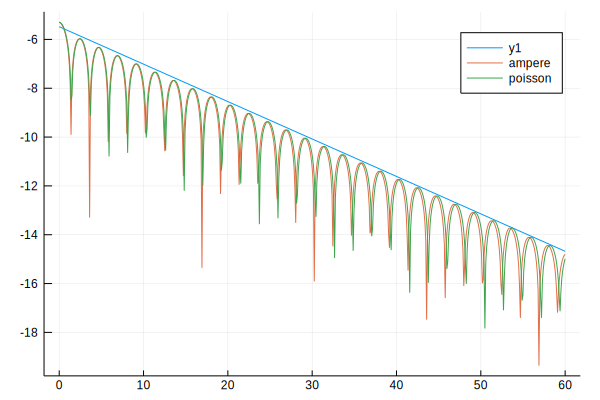

In [50]:
t =  range(0,stop=tf,length=nt)
plot(t, -0.1533*t.-5.48)
plot!(t, vlasov_ampere(nx, nv, xmin, xmax, vmin, vmax, tf, nt), label=:ampere )
plot!(t, vlasov_poisson(nx, nv, xmin, xmax, vmin, vmax, tf, nt), label=:poisson )